# <h1 style="text-align:center;">Stock Price Forecast with Machine Learning</h1>


**Author:** Vitor Hugo Peixoto

### What is a Stock price?
Companies that become public, which means those which the general public can invest onto, are divided in small fractions called shares. Those shares are available for purchase in the form of investment, and the price of each share varies depending on the revenue of said company, the amount of shares at the public disposal, the stability of the company's finances, industry trends and so on... The more shares are purchased the higher the price of each share becomes, following the supply and demand logic. The opposite is also true. The stock price could be affected though by poor management of the company, an economic recession, and many other factors.
In other words, a Stock price is the value of the public sentiment towards publicly traded companies.

In this notebook we aim at analyzing and creating a model to forecast the future stock price of Apple. We'll also prepare other stocks data of some of the most prominent companies in the Stock Market and some of the most known in the world, so we are able in the future to test our model on them or even improve it by analyzing correlations between them. They are: Amazon; Google; Netflix; Nvidia and Tesla.

### What is ARIMA?
Auto Regressive Integrated Moving Average (ARIMA) is a statistical method used for time-series analysis and forecasting. It converts non-stationary data into stationary, and it's a very robust model that is used extensively in fields such as finance, economics, and for forecasting anything that happens throughout a continuous period of time.

## <h1 style="text-align:center;">Table of Content</h1>

* [1. Data visualization](#1)
* [2. Data preprocessing](#2)
    * [2.1 Change index to datetime](#2.1)
    * [2.2 Handle Missing Values](#2.2)
* [3. Exploratory Data Analysis](#3)
    * [3.1 Stationarity](#3.1)
        * [3.1.1 Rolling Mean and Stand. Deviation](#3.1.1)
        * [3.1.2 ACF & PACF](#3.1.2)
        * [3.1.3 Dickey Fuller Test](#3.1.3)
        * [3.1.4 Differencing](#3.1.4)
    * [3.2 Autocorrelation Analysis](#3.2)
* [4. Modeling](#4)
    * [4.1 Data Split](#4.1)
    * [4.2 Fitting the ARIMA Model](#4.2)
        * [4.2.1 Auto Arima](#4.2.1)
        * [4.2.2 Fitting](#4.2.2)
        * [4.2.3 Forecasting](#4.2.3)
* [5. Conclusions](#5)

Let's start by importing the necessary libraries we will be using

In [39]:
# import libraries
import numpy as np
import pandas as pd

# plotting
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns

# time series analysis 
from statsmodels.api import tsa
import statsmodels.api as sm

In [40]:
# read the data 
aapl_df = pd.read_csv(r"C:\Users\vitor\Documents\Brainstation\Capstone\Data\AAPL.csv") # Apple
amzn_df = pd.read_csv(r"C:\Users\vitor\Documents\Brainstation\Capstone\Data\AMZN.csv") # Amazon
googl_df = pd.read_csv(r"C:\Users\vitor\Documents\Brainstation\Capstone\Data\GOOGL.csv") # Google
nflx_df = pd.read_csv(r"C:\Users\vitor\Documents\Brainstation\Capstone\Data\NFLX.csv") # Netflix
nvda_df = pd.read_csv(r"C:\Users\vitor\Documents\Brainstation\Capstone\Data\NVDA.csv") # Nvidia
tsla_df = pd.read_csv(r"C:\Users\vitor\Documents\Brainstation\Capstone\Data\TSLA.csv") # Tesla

<a id='1'></a>
### Data Visualization

In [41]:
# visualize the first 5 rows
aapl_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-01-05,3.327500,3.435000,3.311071,3.377857,2.863342,1181608400
1,2009-01-06,3.426786,3.470357,3.299643,3.322143,2.816114,1289310400
2,2009-01-07,3.278929,3.303571,3.223571,3.250357,2.755262,753048800
3,2009-01-08,3.229643,3.326786,3.215714,3.310714,2.806425,673500800
4,2009-01-09,3.328929,3.335000,3.219286,3.235000,2.742244,546845600


This data goes from January 2009 until December of 2023 (The start date is the same for all dataframes but Tesla) with 7 features recorded in all of them:
- **Date** indicates the specific day when the stock was traded.
- **Open** means the price which the stock started being traded as the moment the trading day began.
- **High/Low** represents, respectively, the highest and lowest intra day price of the stock.
- **Close** indicates the price of the stock at the moment the trading day ended.
- **Adj Close** (Adjusted Close) reflects the actual price of the stock corporate actions, such as payment of dividends.
- **Volume** signifies the amount of trades that happened during the specified period (daily in this case).

In [42]:
# summary of statistics for each column
aapl_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3762.000000,3762.000000,3762.000000,3762.000000,3762.000000,3.762000e+03
mean,55.841781,56.447948,55.265455,55.883659,53.952384,2.645531e+08
std,54.783873,55.412172,54.211841,54.844534,55.143366,2.345229e+08
min,2.835357,2.928571,2.792857,2.792857,2.367448,2.404830e+07
25%,17.477055,17.613302,17.278126,17.449375,15.170636,9.604302e+07
50%,29.679999,29.918751,29.454999,29.748750,27.163373,1.674684e+08
75%,75.055626,75.962500,74.248751,75.140001,73.334129,3.784949e+08
max,196.240005,198.229996,195.279999,197.960007,197.960007,1.880998e+09


In [10]:
# look at the shape of the data (rows and columns, respectively)
print(aapl_df.shape)
print(amzn_df.shape)
print(googl_df.shape)
print(nflx_df.shape)
print(nvda_df.shape)
print(tsla_df.shape)

(3762, 7)
(3762, 7)
(3762, 7)
(3762, 7)
(3762, 7)
(3388, 7)


All datasets have the same structure of 3762 rows and 7 columns. All but Tesla, because the company hasn't entered the Stock Market until 2010, and the other datasets start at 2009.

We can visualize the performance of the Apple stock by using `Plotly`'s candlestick chart, a very useful chart to look at stock data. Whenever we get a red bar, it means the stock price that day went down. When we get a green bar it means it went up.

In [47]:
# create a candlestick chart for AAPL
fig = go.Figure(data=[go.Candlestick(x = aapl_df['Date'],
                                     open = aapl_df['Open'],
                                     high = aapl_df['High'],
                                     low = aapl_df['Low'],
                                     close = aapl_df['Close'])])

fig.update_layout(title=dict(text='Apple Stock', x=0.5, y=0.95), xaxis_title='Date', yaxis_title='Stock Price')
fig.show()

<a id='2'></a>
### Data Preprocessing

<a id='2.1'></a>
In order to make a Time-Series analysis we need to index the dataframe based on the 'Date' column, using a function from pandas `to_datetime`

In [48]:
# changing the indexes of the dataframes using the pandas function 'to_datetime'
# Apple
aapl_df['Date'] = pd.to_datetime(aapl_df['Date'])
aapl_df = aapl_df.set_index('Date')
aapl_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-01-05,3.327500,3.435000,3.311071,3.377857,2.863342,1181608400
2009-01-06,3.426786,3.470357,3.299643,3.322143,2.816114,1289310400
2009-01-07,3.278929,3.303571,3.223571,3.250357,2.755262,753048800
2009-01-08,3.229643,3.326786,3.215714,3.310714,2.806425,673500800
2009-01-09,3.328929,3.335000,3.219286,3.235000,2.742244,546845600


In [49]:
# Amazon
amzn_df['Date'] = pd.to_datetime(amzn_df['Date'])
amzn_df = amzn_df.set_index('Date')
# Google
googl_df['Date'] = pd.to_datetime(googl_df['Date'])
googl_df = googl_df.set_index('Date')
# Netflix
nflx_df['Date'] = pd.to_datetime(nflx_df['Date'])
nflx_df = nflx_df.set_index('Date')
# Nvidia
nvda_df['Date'] = pd.to_datetime(nvda_df['Date'])
nvda_df = nvda_df.set_index('Date')
# Tesla
tsla_df['Date'] = pd.to_datetime(tsla_df['Date'])
tsla_df = tsla_df.set_index('Date')

print(amzn_df.head(2))
print(googl_df.head(2))
print(nflx_df.head(2))
print(nvda_df.head(2))
print(tsla_df.head(2))

              Open   High     Low  Close  Adj Close     Volume
Date                                                          
2009-01-05  2.7865  2.787  2.6515  2.703      2.703  190196000
2009-01-06  2.7275  2.911  2.6875  2.868      2.868  221602000
                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2009-01-05  8.033033  8.289289  7.882883  8.209459   8.209459  195364440
2009-01-06  8.332833  8.528529  8.167918  8.359860   8.359860  256750992
                Open      High       Low     Close  Adj Close    Volume
Date                                                                   
2009-01-05  4.327143  4.562857  4.302857  4.562857   4.562857  13044500
2009-01-06  4.591429  4.750000  4.590000  4.705714   4.705714  12065900
              Open    High     Low   Close  Adj Close    Volume
Date                                                           
2009-01-05  2.1525  2.2675  2.1375  2.21

Now our data's index is set as datetime. It is a recommended procedure to do this when analyzin a time-series. 

We are ready to take a first look into our charts using `matplotlib`.

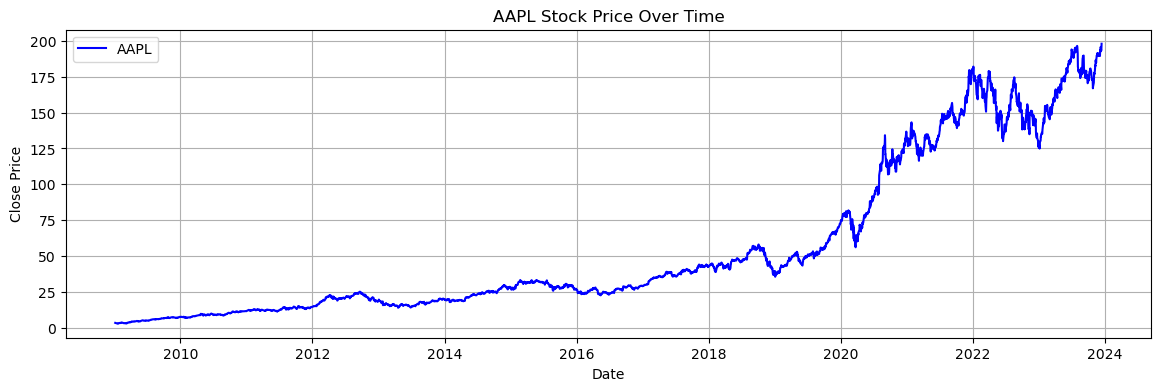

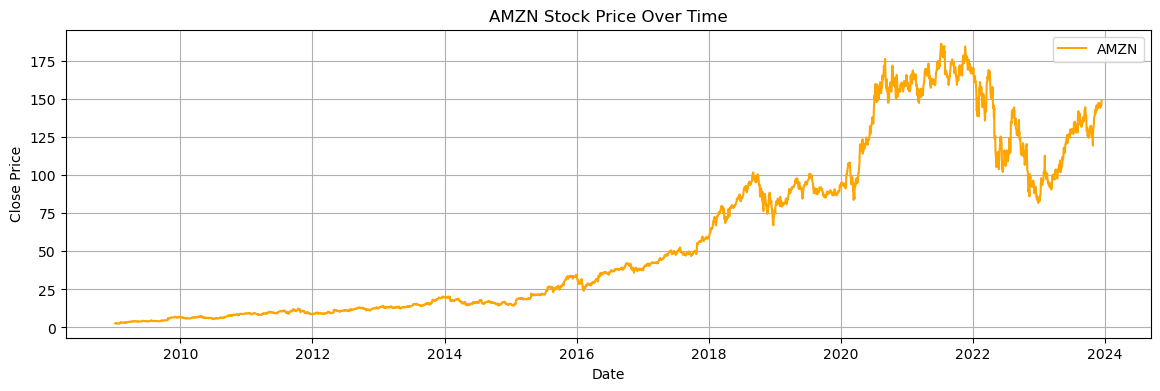

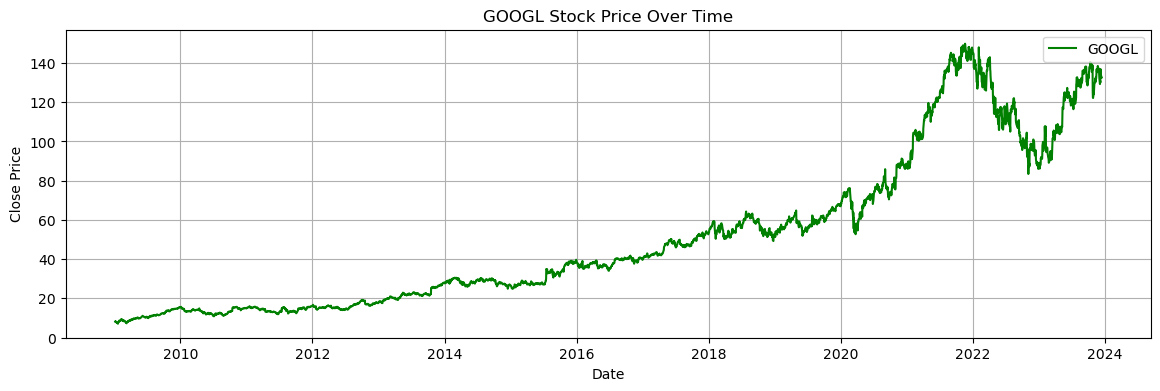

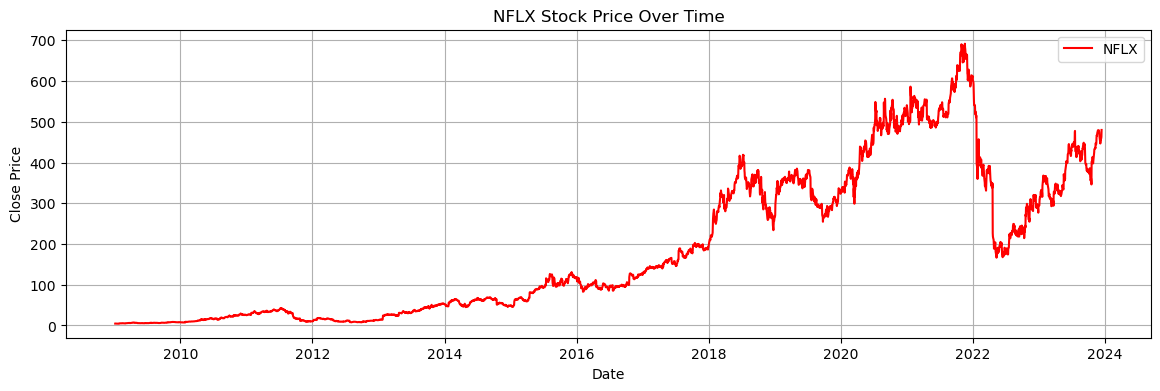

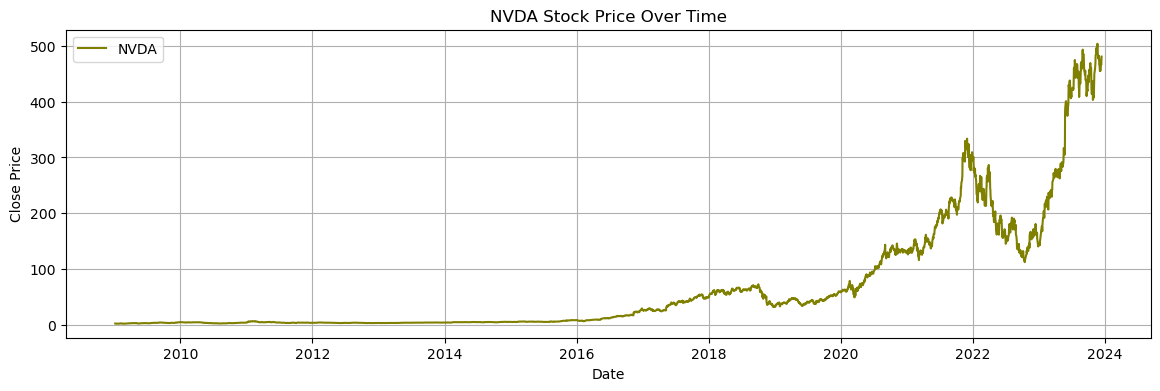

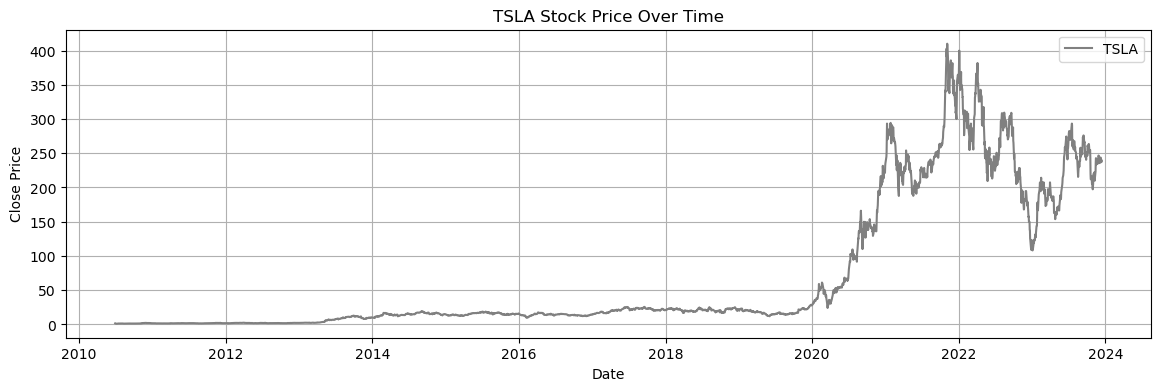

In [51]:
# visualize the charts for each stock
# Apple
plt.figure(figsize=(14, 4))
plt.plot(aapl_df['Close'], label='AAPL', color='blue')

plt.title('AAPL Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

# Amazon
plt.figure(figsize=(14, 4))
plt.plot(amzn_df['Close'], label='AMZN', color='orange')

plt.title('AMZN Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

# Google
plt.figure(figsize=(14, 4))
plt.plot(googl_df['Close'], label='GOOGL', color='green')

plt.title('GOOGL Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

# Netflix
plt.figure(figsize=(14, 4))
plt.plot(nflx_df['Close'], label='NFLX', color='red')

plt.title('NFLX Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

# Nvidia
plt.figure(figsize=(14, 4))
plt.plot(nvda_df['Close'], label='NVDA', color='olive')

plt.title('NVDA Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.legend()
plt.show()

# Tesla
plt.figure(figsize=(14, 4))
plt.plot(tsla_df['Close'], label='TSLA', color='gray')

plt.title('TSLA Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.legend()
plt.show()

There are many factors that can influence the price to go up. Perhaps one of them might be the volume that the stock is traded at. \
To visualize if there might be any correlation there we can plot them together. The assumption is that if the volume increases, so should the stock price.

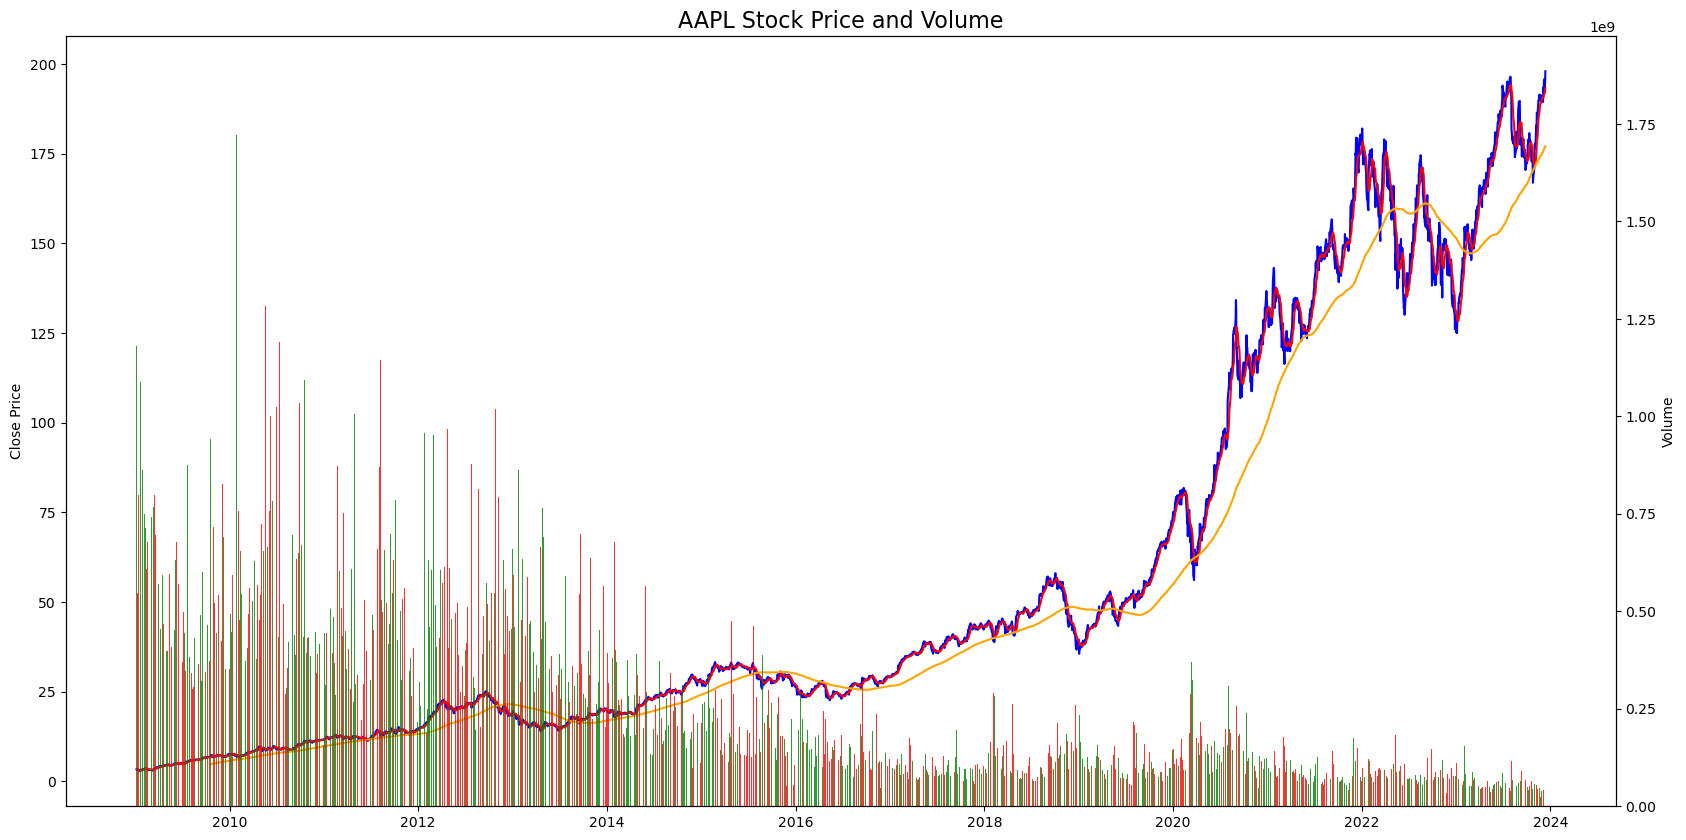

In [53]:
# set a variable for the closing of the day prior
close_price_shifted = aapl_df['Close'].shift(1)

# calculate the 100-day moving average
aapl_df_200 = aapl_df['Close'].rolling(window=200).mean()
aapl_df_100 = aapl_df['Close'].rolling(window=100).mean()
aapl_df_10 = aapl_df['Close'].rolling(window=10).mean()

# create subplots
fig, ax1 = plt.subplots(figsize=[20, 10])

# plot the stock price on the y-axis
ax1.plot(aapl_df.index, aapl_df['Close'], color='blue')
ax1.plot(aapl_df.index, aapl_df_10, color='red', label='10-day Moving Average')
ax1.plot(aapl_df.index, aapl_df_200, color='orange', label='200-day Moving Average')

ax1.set_ylabel('Close Price')

ax2 = ax1.twinx()

# Color the volume bars and plot it on the y-axis on the right
volume_colors = ['red' if close_price < close_price_shifted else 'green' for close_price, close_price_shifted in zip(aapl_df['Close'], close_price_shifted)]
ax2.bar(aapl_df.index, aapl_df['Volume'], color=volume_colors, alpha=0.8, label='Volume')
ax2.set_ylabel('Volume')

plt.title('AAPL Stock Price and Volume', fontsize=16)

plt.show()

As we can see, the volume doesn't have much influence on the price of the stock, at least not the way we first thought. The only way it can be influenced is if a big number of people is either buying or selling their shares. If that number is equaly divided then the stock price tends to be stagnant.

<a id='2.2'></a>
### Missing values and dates

Despite believing the data is perfectly clean, we'll perform a quick analysis to make sure there are absolutely no missing dates and/or values. Due to the nature of stock trading, there will be missing dates for Saturdays, Sundays and Holidays, days which the stock market is closed, so we'll account for that and delete these rows if they exist. 

From here on we'll do our due diligence on the Apple stock and apply the concepts to the other stocks in due time, considering that they all follow the same data parameter which is mandatory in publicly traded stocks.

In [54]:
# check for missing values
aapl_df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

There are no missing values. However we do expect to see missing dates. Let's see exactly how many days are missing and how to deal with them.

In [55]:
# save the first and last days in variables
first_day = aapl_df.index.min()
last_day = aapl_df.index.max()

# stablish the full range of the dataset by business days
full_range = pd.date_range(start=first_day, end=last_day, freq="b")

# calculate the total amount of missing days
aapl_missing_days = full_range.difference(aapl_df.index)

print(aapl_missing_days)

DatetimeIndex(['2009-01-19', '2009-02-16', '2009-04-10', '2009-05-25',
               '2009-07-03', '2009-09-07', '2009-11-26', '2009-12-25',
               '2010-01-01', '2010-01-18',
               ...
               '2022-12-26', '2023-01-02', '2023-01-16', '2023-02-20',
               '2023-04-07', '2023-05-29', '2023-06-19', '2023-07-04',
               '2023-09-04', '2023-11-23'],
              dtype='datetime64[ns]', length=136, freq=None)


In [17]:
# visualize the first and last days
first_day, last_day

(Timestamp('2009-01-05 00:00:00'), Timestamp('2023-12-13 00:00:00'))

In [59]:
# total number of missing days
len(aapl_missing_days)

136

We have set a variable with the full range of our index being from the first day recorded to the last day recorded following a period of business days. 

The stock market does not open on weekends and holidays, therefore we'll not account for weekend values. 

We already know the number of days missing, which is 136, but as we reindex our data, they should show when we use the `isna()` method.

In [60]:
# reindexing the data
# Apple
aapl_df_clean = aapl_df.reindex(full_range)
# Amazon
amzn_df_clean = amzn_df.reindex(full_range)
# Google
googl_df_clean = googl_df.reindex(full_range)
# Netflix
nflx_df_clean = nflx_df.reindex(full_range)
# Nvidia
nvda_df_clean = nvda_df.reindex(full_range)
# Tesla
tsla_df_clean = tsla_df.reindex()


In [61]:
# check if the new dates were indexed
aapl_df_clean.head(20)

,Open,High,Low,Close,Adj Close,Volume
2009-01-05,3.327500,3.435000,3.311071,3.377857,2.863342,1.181608e+09
2009-01-06,3.426786,3.470357,3.299643,3.322143,2.816114,1.289310e+09
2009-01-07,3.278929,3.303571,3.223571,3.250357,2.755262,7.530488e+08
2009-01-08,3.229643,3.326786,3.215714,3.310714,2.806425,6.735008e+08
2009-01-09,3.328929,3.335000,3.219286,3.235000,2.742244,5.468456e+08
2009-01-12,3.230714,3.249643,3.126786,3.166429,2.684118,6.177164e+08
2009-01-13,3.151429,3.205000,3.083929,3.132500,2.655356,7.983976e+08
2009-01-14,3.080000,3.116071,3.025714,3.047500,2.583303,1.021664e+09
2009-01-15,2.877500,3.004286,2.858929,2.977857,2.524269,1.831634e+09
2009-01-16,3.010714,3.013571,2.871429,2.940357,2.492481,1.047626e+09


In [62]:
# observe if the number of null values changes since we created new rows
aapl_df_clean.isna().sum()

Open         136
High         136
Low          136
Close        136
Adj Close    136
Volume       136
dtype: int64

Confirming what we already knew, there are 136 days missing from our dataset over the periods of 2009-01-05 and 2023-12-13. 

We are going to visualize how distante these null values are from each other to determine the best way to deal with them.

Proceeding, we will fill these values so we have a very consistent time series with daily values for business days periods.

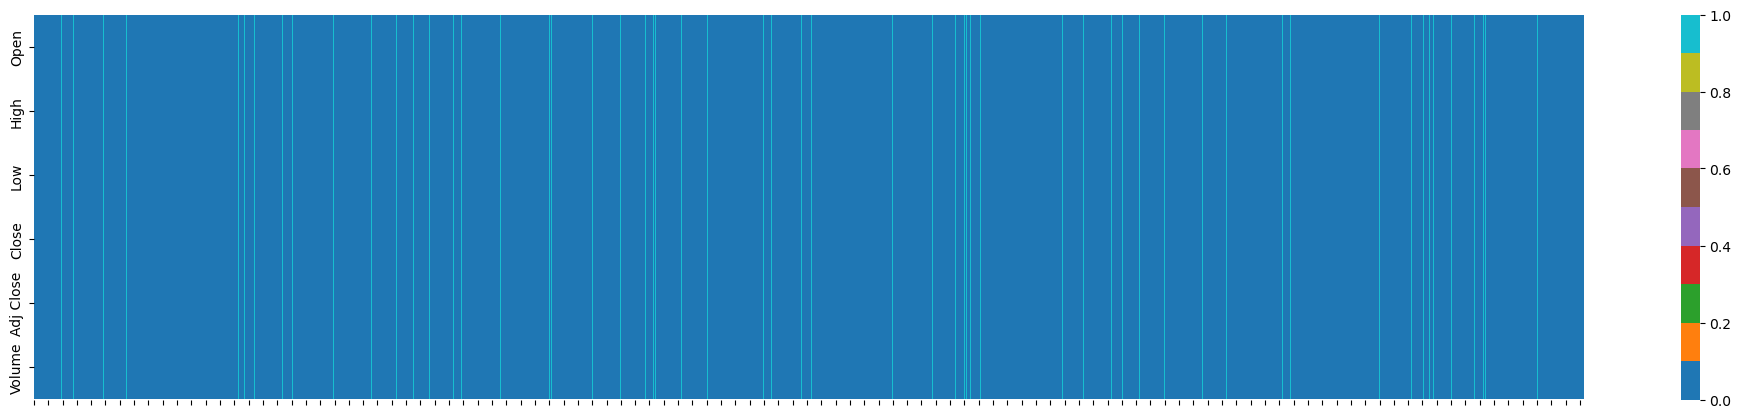

In [63]:
# visualize the distribution of the null values throughout our dataframe
plt.figure(figsize=(25, 5))
ax = sns.heatmap(aapl_df_clean.isna().T, cmap="tab10", cbar="False")
ax.set(xticklabels=[])

plt.show()

Since the null values are distant from each other and well distributed in the extension of our dataframe, We will use `forward fill` to populate these rows. 

In [64]:
# fill the missing values using forward fill
# Apple
aapl_df_clean = aapl_df_clean.fillna(method="ffill")
# Amazon
amzn_df_clean = amzn_df_clean.fillna(method="ffill")
# Google
googl_df_clean = googl_df_clean.fillna(method="ffill")
# Netflix
nflx_df_clean = nflx_df_clean.fillna(method="ffill")
# Nvidia
nvda_df_clean = nvda_df_clean.fillna(method="ffill")
# Tesla
tsla_df_clean = tsla_df_clean.fillna(method="ffill")

C:\Users\vitor\AppData\Local\Temp\ipykernel_15856\1607699598.py:3: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\vitor\AppData\Local\Temp\ipykernel_15856\1607699598.py:5: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\vitor\AppData\Local\Temp\ipykernel_15856\1607699598.py:7: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\vitor\AppData\Local\Temp\ipykernel_15856\1607699598.py:9: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\vitor\AppData\Local\Temp\ipykernel_15856\1607699598.py:11: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill()

In [65]:
# cheack if there are any missing values still. Substitute the dataframe as needed.
aapl_df_clean.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

With a reindexed and cleaned data without null values or missing dates, we can continue the exploratory analysis.

<a id='3'></a>
### Exploratory Data Analysis

The probability distribution of stock prices provides insights into the likely range of future price movements based on the data. We can plot it to 

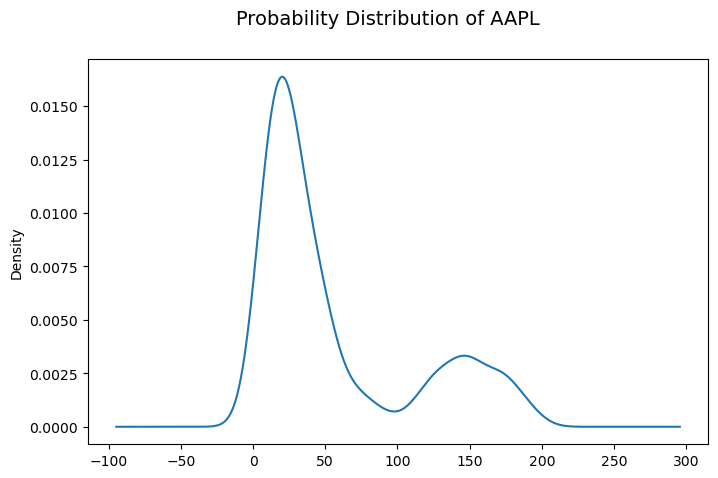

In [70]:
# plot the probability distribution
fig, ax = plt.subplots(figsize=(8, 5))
fig.suptitle('Probability Distribution of AAPL', size=14)

aapl_df_clean['Close'].plot(kind='kde', ax=ax)
plt.show()

In a Kernel Density Estimation (KDE) probability distribution plot, the x-axis represents the values of the AAPL stock price, and the y-axis represents the estimated probability for each corresponding value.

Because we are using a dataset that goes from 2009 until 2023, this plot shows the price has a higher probability to be between 0 and 50, possibly because the price has stayed in this range for a longer period of time. But knowing stock prices, this is likely in the near future, so we should discard it.

In [71]:
# set simple moving averages
aapl_sma_100 = aapl_df_clean['Close'].rolling(window=100).mean()
aapl_sma_10 = aapl_df_clean['Close'].rolling(window=10).mean()

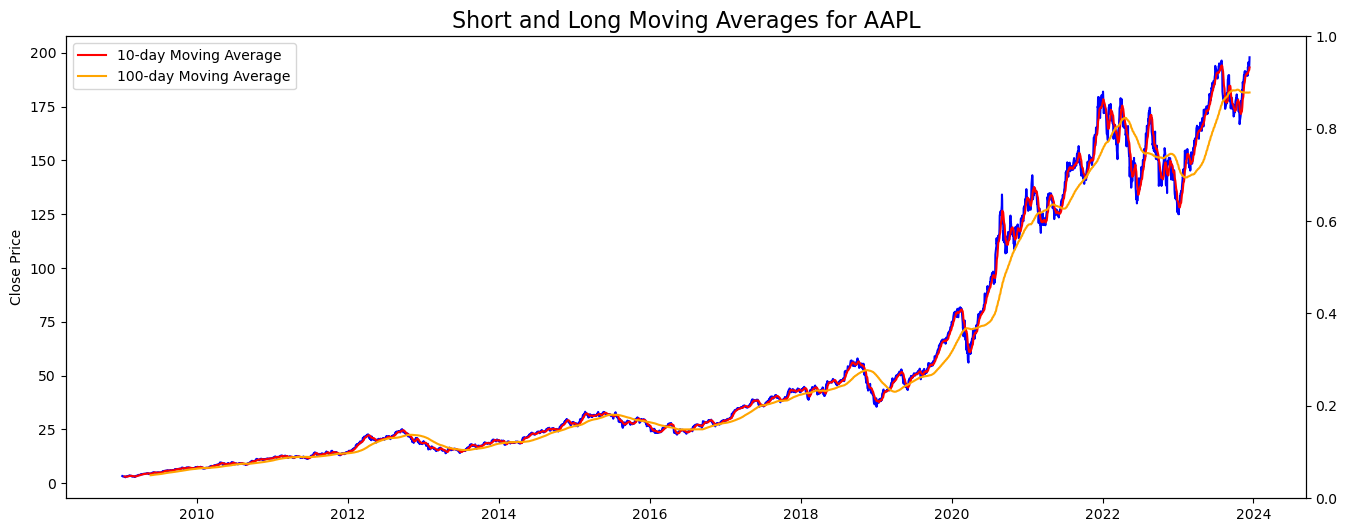

In [75]:
# create subplots
fig, ax1 = plt.subplots(figsize=[16, 6])

# plot the stock price on the y-axis
ax1.plot(aapl_df_clean.index, aapl_df_clean['Close'], color='blue')
ax1.plot(aapl_df_clean.index, aapl_sma_10, color='red', label='10-day Moving Average')
ax1.plot(aapl_df_clean.index, aapl_sma_100, color='orange', label='100-day Moving Average')

ax1.set_ylabel('Close Price')

ax2 = ax1.twinx()

plt.title('Short and Long Moving Averages for AAPL', fontsize=16)
ax1.legend(loc='best')
plt.show()

In the Stock Market, two common metrics to understand a company's price is the `Simple Moving Average`(SMA) and the `Exponential Moving Average`(EMA). The first is built by calculating the average of a set number of past prices while the latter does the same, but giving different 'weights' to the prices depending on how closer they are to the current day.

The SMA line is regarded as being a good indicator as to when a stock should be purchased, whereas the EMA is regarded as a good indicator to when a stock should be sold. 

That being said, we'll analyse how these lines move together and perhaps create a model that takes them into consideration.

In [76]:
# set a 10-day exponential moving average
aapl_ema_10 = aapl_df_clean['Close'].ewm(span=10, adjust=False).mean()

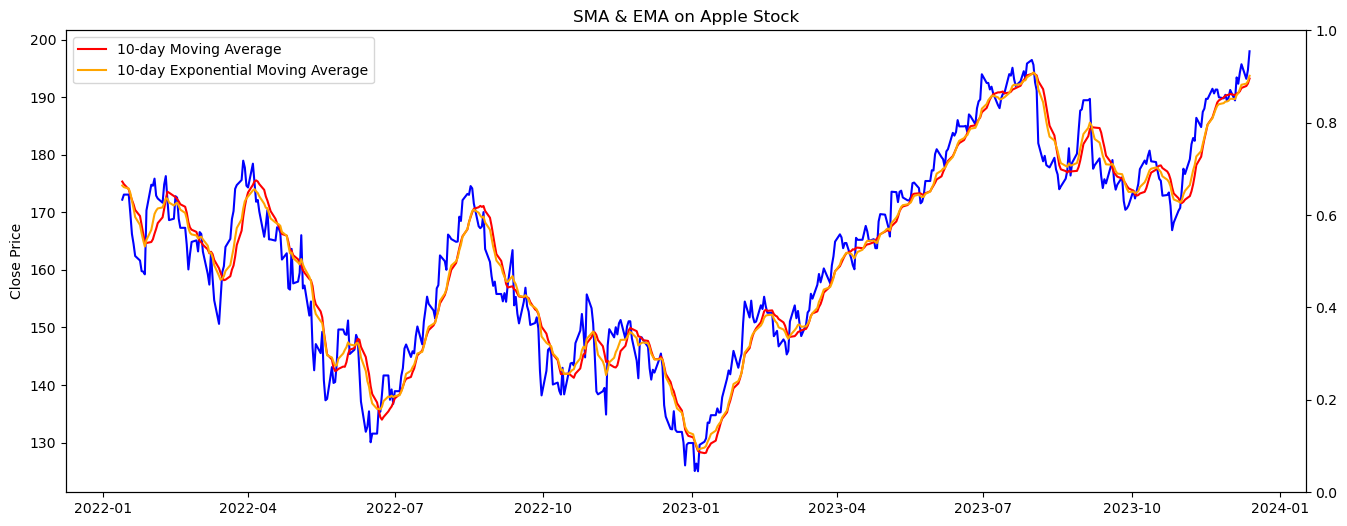

In [77]:
# plot the last 500 days visualizing the EMA and SMA
# create subplots
fig, ax1 = plt.subplots(figsize=[16, 6])

# plot the stock price on the y-axis
ax1.plot(aapl_df_clean.index[-500:], aapl_df_clean['Close'][-500:], color='blue')
ax1.plot(aapl_df_clean.index[-500:], aapl_sma_10[-500:], color='red', label='10-day Moving Average')
ax1.plot(aapl_df_clean.index[-500:], aapl_ema_10[-500:], color='orange', label='10-day Exponential Moving Average')

ax1.set_ylabel('Close Price')

ax2 = ax1.twinx()

plt.title('SMA & EMA on Apple Stock')
ax1.legend(loc='best')
plt.show()

<a id='3.1'></a>
### Stationarity Test

<a id='3.1.1'></a>
A time series is regarded as having three systematic components(level, trend, seasonality), and one non-systematic component(residuals). However, to predict the future of a time series it's a good practice to strip the data from any trend or seasonality it posses.

We must then determine whether a series is stationary or not A time series is considered stationary when its statistical properties, such as mean and variance, remain constant over time.

In [78]:
from statsmodels.tsa.stattools import adfuller

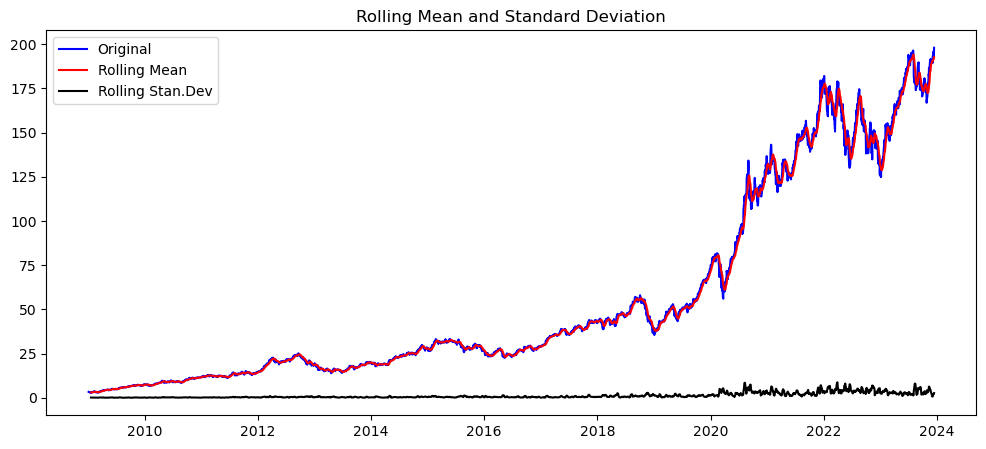

In [79]:
# visualize if it's stationary by looking at the mean variation
def test_stationarity(timeseries):
    # determine rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    # plot the graphic
    plt.figure(figsize=(12, 5))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Stan.Dev')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
test_stationarity(aapl_df_clean['Close'])

We can see in our graphic both the `mean` and `standard deviation` are not constant, therefore our data is not stationary.

Another interesting approach is decomposing our data and seeing how closely the trend follows the actual stock chart.

In [80]:
# import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose

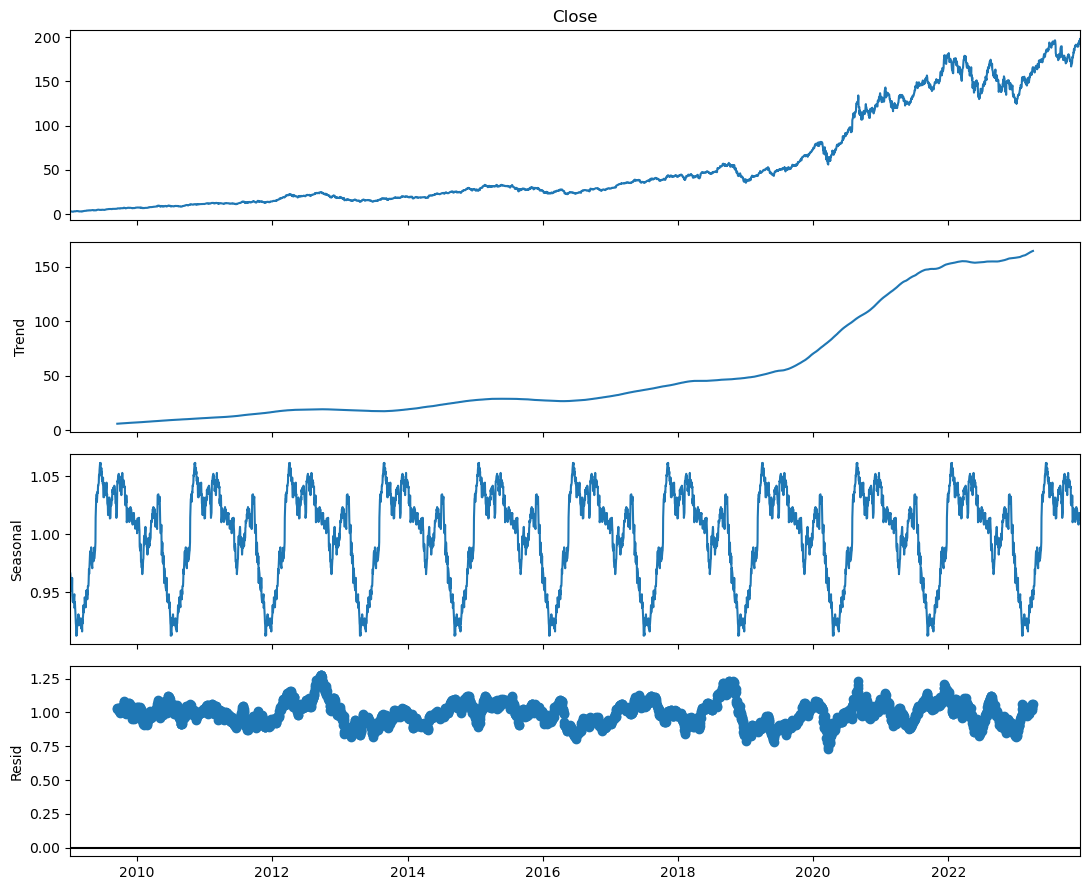

In [81]:
# plot the seasonal decomposition
plt.rcParams['figure.figsize'] = (11, 9)
decomposed_aapl = sm.tsa.seasonal_decompose(aapl_df_clean["Close"],model="multiplicative", period=365)
figure = decomposed_aapl.plot()
plt.show()

<a id='3.1.2'></a>
We have decomposed the data into `Trend`, `Seasonality` and `Residual`. Since the trend follows the data closely, we can 
look at the correlation of past and present values and see how they relate to each other.

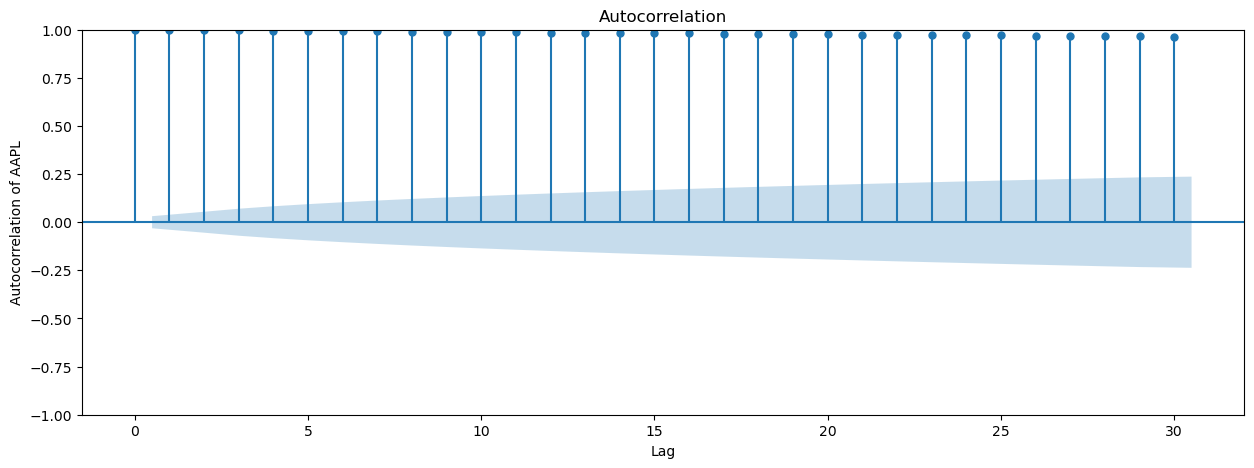

In [82]:
# plot the auto-correlation of our data
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(15, 5))

plot_acf(aapl_df_clean['Close'], lags=30, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation of AAPL')
plt.show()

Looking at the graphic above we can see a high correlation between the prices of a closer period, based on how far the lines go from zero. And seeing how they decreased slightly as the lags increase, it shows us the prices are more likely to be correlated to shorter distance prices than longer periods, even though we could still use values from a month back as good estimators.

The coefficients are also significant, which is an indicator of time dependency on the data.

Let's see if we can draw more insights from a partial auto-correlation method.

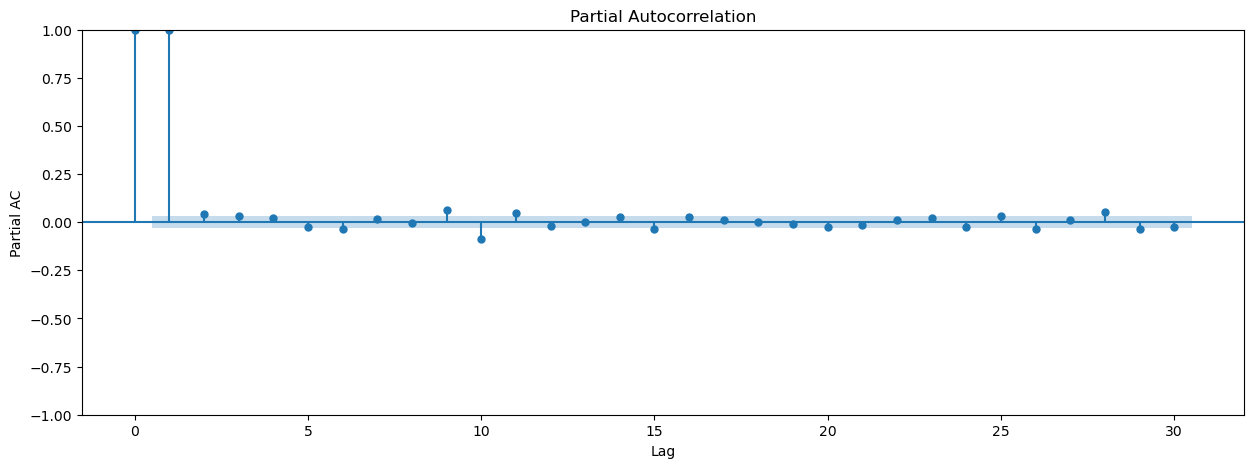

In [83]:
# plot a partial auto-correlation method
plt.figure(figsize=(15, 5))
plot_pacf(aapl_df_clean['Close'], lags=30, method='ols', ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Partial AC')
plt.show()

Looking at the Partial Auto-Correlation, we see a slight significance on lag 9 and 10, the first being positively autocorrelated and the latter being negatively autocorrelated, but the first lag being extremelly correlated to the current price. This could help us determining the p parameter. However, we still need to check the stationarity of the data. If it is not stationary, then we'll need to run this correlation again after modifying the values.

<a id='3.1.3'></a>
In order to check if the data is currently stationary we can run a Dickey Fuller test.

In [84]:
# perform Dickey Fuller test
print("Results of dickey fuller test")
adft = adfuller(aapl_df_clean['Close'],autolag='AIC')
   
output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
for key,values in adft[4].items():
    output['critical value (%s)'%key] =  values
print(output)

Results of dickey fuller test
Test Statistics                   1.090509
p-value                           0.995135
No. of lags used                 29.000000
Number of observations used    3868.000000
critical value (1%)              -3.432042
critical value (5%)              -2.862288
critical value (10%)             -2.567168
dtype: float64


We could already see our data wasn't stationary by analyzing the graphic showing the rolling mean and standard deviation increasing over time. However, by running a Dickey Fuller test we can categorically deny the null hypothesis that the data was stationary by having a `p-value` result of over 99%.

In order to perform a better time series analysis, we'll proceed using `percentage change` to de-trend our stock, as well as `differencing` the value with the one before, which will take our data closer to stationaryty. We will choose, then, either the percentage change(returns) or the differenced data to fit our model. It'll be chosen after analising their different performances when plotting the autocorrelation graphic (ACF) on the stationary data.

### Reducing the Data to Stationary

<a id='3.1.4'></a>
One common indice in the financial market when looking at stock prices is `returns`. Simply put, it's the percentage change from one period to the next. In this case, we are not so worried about the price of the stock, but if it'll go up or down, and by how much. In other words, if the percentage difference from one date to the next is positive, it means the stock went up, if negative, then the stock went down.

In [87]:
# create new feature based on percentage change of price
aapl_df_clean['Returns'] = aapl_df_clean['Close'].pct_change(1).mul(100)
returns = aapl_df_clean['Returns'].dropna()
returns

2009-01-06   -1.649389
2009-01-07   -2.160834
2009-01-08    1.856934
2009-01-09   -2.286939
2009-01-12   -2.119660
                ...   
2023-12-07    1.013934
2023-12-08    0.741238
2023-12-11   -1.292736
2023-12-12    0.792015
2023-12-13    1.669149
Freq: B, Name: Returns, Length: 3897, dtype: float64

In [88]:
# create new feature based on the difference change of price
aapl_df_clean['Diff'] = aapl_df_clean['Close'].diff(1)
difference = aapl_df_clean['Diff'].dropna()
difference

2009-01-06   -0.055714
2009-01-07   -0.071786
2009-01-08    0.060357
2009-01-09   -0.075714
2009-01-12   -0.068571
                ...   
2023-12-07    1.949997
2023-12-08    1.440003
2023-12-11   -2.530014
2023-12-12    1.530014
2023-12-13    3.250000
Freq: B, Name: Diff, Length: 3897, dtype: float64

In [89]:
# perform Dickey Fuller test on returns
print("Results of dickey fuller test")
adft = adfuller(returns,autolag='AIC')
   
output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
for key,values in adft[4].items():
    output['critical value (%s)'%key] =  values
print(output)

Results of dickey fuller test
Test Statistics               -1.654862e+01
p-value                        1.954275e-29
No. of lags used               1.300000e+01
Number of observations used    3.883000e+03
critical value (1%)           -3.432035e+00
critical value (5%)           -2.862285e+00
critical value (10%)          -2.567166e+00
dtype: float64


In [90]:
# perform Dickey Fuller test on differenced data
print("Results of dickey fuller test")
adft = adfuller(difference, autolag='AIC')
   
output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
for key,values in adft[4].items():
    output['critical value (%s)'%key] =  values
print(output)

Results of dickey fuller test
Test Statistics               -1.109449e+01
p-value                        4.005500e-20
No. of lags used               2.800000e+01
Number of observations used    3.868000e+03
critical value (1%)           -3.432042e+00
critical value (5%)           -2.862288e+00
critical value (10%)          -2.567168e+00
dtype: float64


As we can see with the extremelly low indice of the Dickey Fuller test p-value, both the percentage change and differencing of our data worked to make the data stationary.

We can plot both to see how they look in comparison with each other.

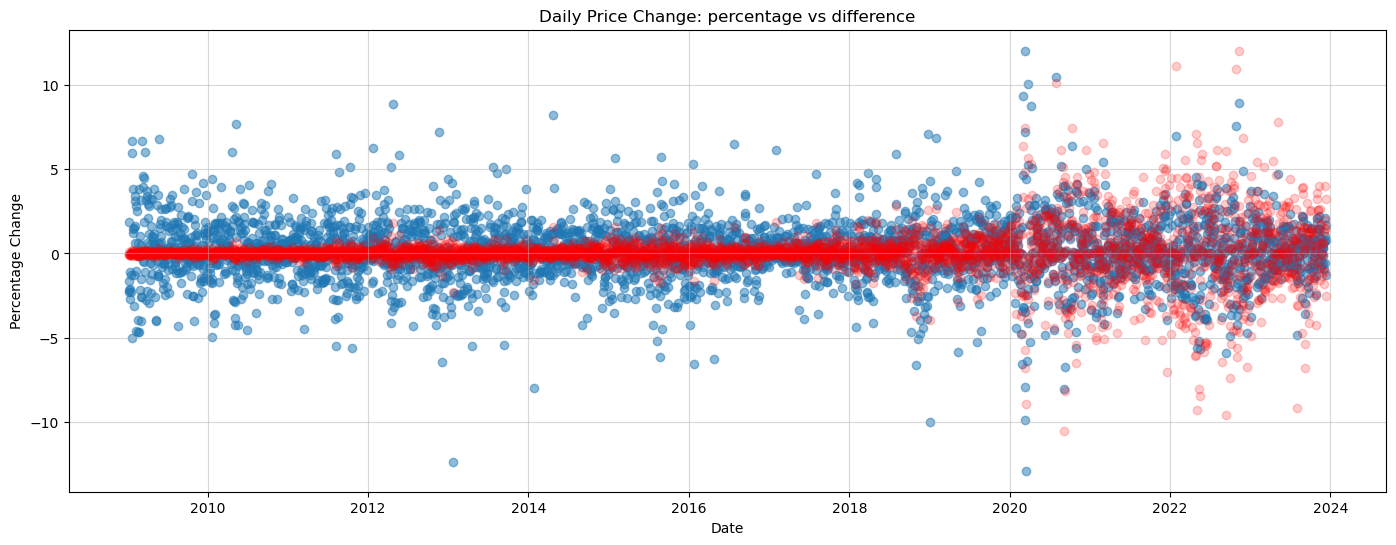

In [91]:
# plot the percentage vs the differencing of the data per day of trading
plt.figure(figsize=(17, 6))
plt.scatter(returns.index, returns, alpha=0.5)
plt.scatter(difference.index, difference, color='r', alpha=0.2)
 
plt.title('Daily Price Change: percentage vs difference')
plt.xlabel('Date')
plt.ylabel('Percentage Change')
plt.grid(True, alpha=0.5)
plt.show()

<a id='3.2'></a>
By using either returns or differencing instead of the closing price, we can have a stationary data, as we can verify also by the lower test statistic compared to the critical values.

In order to visualize this stationarity, we can pass our data through the autocorrelation method. In theory, we shouldn't see minimal spikes on the lines.

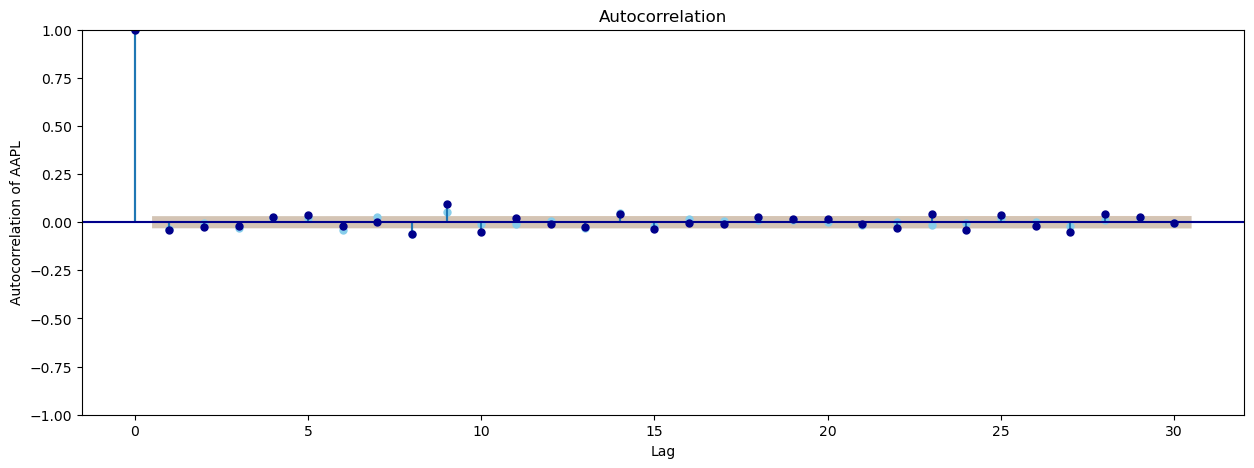

In [92]:
# plot the auto-correlation of our data
plt.figure(figsize=(15, 5))

plot_acf(returns, lags=30, ax=plt.gca(), color='skyblue')
plot_acf(difference, lags=30, ax=plt.gca(), color='darkblue')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation of AAPL')

plt.show()

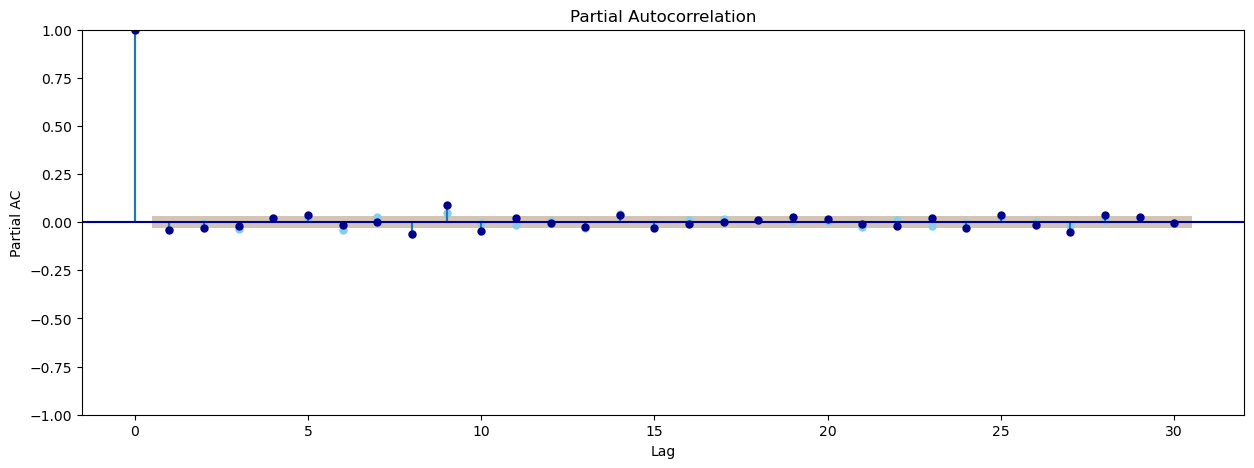

In [93]:
# plot a partial auto-correlation method
plt.figure(figsize=(15, 5))

plot_pacf(returns, lags=30, method='ols', ax=plt.gca(), color='skyblue')
plot_pacf(difference, lags=30, method='ols', ax=plt.gca(), color='darkblue')
plt.xlabel('Lag')
plt.ylabel('Partial AC')

plt.show()

Now both the `ACF` and the `PACF` are fairly similar. The first 3 lags of negative coefficients let us interpret the price having a negative impact on the subsequent values. That's expected, seeing the cyclical nature of stock prices.

For this model, we are going to use `difference`, simply because the lines on the PACF and ACF charts go slightly up, which might yield extra information for our model to use on its prediction. Nonetheless, we'll also follow up with the returns stationary data in case we need a different method of prediction down the line.

<a id='4'></a>
### Forecasting using ARIMA

The first model we'll use to perform our prediction is ARIMA (AutoRegressive Integrated Moving Average). ARIMA is a popular and powerful time series forecasting model that is also widely used in the finance market.

We'll start by saving key values in variables. 

In [95]:
# first day train set for returns
first_day_train_r = returns.index[0]

# last day train set for returns
last_day_train_index_r = int(len(returns) * 0.8) - 1
last_day_train_r = returns.index[last_day_train_index_r]

# first day test set for returns
first_day_test_index_r = int(len(returns) * 0.8)
first_day_test_r = returns.index[first_day_test_index_r]

# last day test set for returns
last_day_test_r = returns.index[-1]

# first day test set original
first_day_test_index = int(len(aapl_df_clean) * 0.8)
first_day_test = aapl_df_clean.index[first_day_test_index]


In [96]:
# first day train set for difference
first_day_train_d = difference.index[0]

# last day train set for difference
last_day_train_index_d = int(len(difference) * 0.8) - 1
last_day_train_d = difference.index[last_day_train_index_d]

# first day test setfor difference
first_day_test_index_d = int(len(difference) * 0.8)
first_day_test_d = difference.index[first_day_test_index_d]

# last day test set for difference
last_day_test_d = difference.index[-1]


In [97]:
# sanity check that the dates were saved correctly
print(first_day_train_r)
print(last_day_train_r)
print(first_day_test_r)
print(last_day_test_r)
print('*****************')
print(first_day_train_d)
print(last_day_train_d)
print(first_day_test_d)
print(last_day_test_d)

2009-01-06 00:00:00
2020-12-16 00:00:00
2020-12-17 00:00:00
2023-12-13 00:00:00
*****************
2009-01-06 00:00:00
2020-12-16 00:00:00
2020-12-17 00:00:00
2023-12-13 00:00:00


<a id='4.1'></a>
The dates were saved correctly in individual variables. With that, we can now easiliy split our data into Train and Test to fit our ARIMA model.

In [98]:
# split the returns data
train_data_r = returns[:last_day_train_r]
test_data_r = returns[first_day_test_r:]

test_data_original = aapl_df_clean['Close'][first_day_test:] # test data with original values

# split the difference data
train_data_d = difference[:last_day_train_d]
test_data_d = difference[first_day_test_d:]

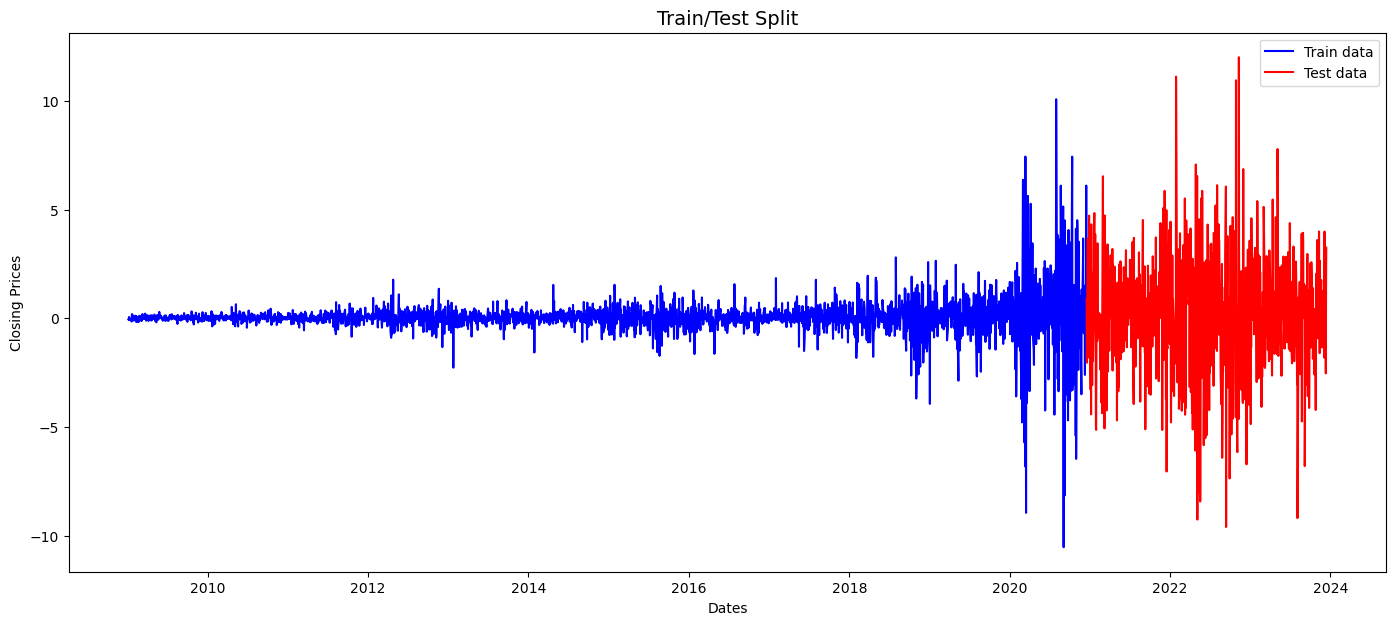

In [101]:
# plot the split data
plt.figure(figsize=(17, 7))

plt.plot(train_data_d, 'b', label='Train data')
plt.plot(test_data_d, 'r', label='Test data')

plt.grid(False)
plt.title('Train/Test Split', fontsize=14)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.legend()
plt.show()

<a id='4.2.1'></a>
The ARIMA model takes three main order parameters: p, q and d. `p` is the order of the Auto Regressive component, `q` is the difference and `d` is the order of the Moving Average component.
In order to find the best parametrers we'll run an `Auto ARIMA` funtion. It'll help us discover the optimal values for our model.

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7844.186, Time=0.43 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=7798.601, Time=0.34 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=7799.084, Time=0.38 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=7800.496, Time=0.39 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=7800.530, Time=0.36 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=7770.934, Time=0.98 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=7764.131, Time=1.41 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=7799.873, Time=0.38 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=7761.299, Time=1.51 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=7801.586, Time=0.52 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=7746.429, Time=1.55 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=7795.207, Time=0.53 sec
 ARIMA(6,0,1)(0,0,0)[0]             : AIC=7740.966, Time=1.41 sec
 ARIMA(6,0,0)(0,0,0)[0]             : AIC=7791.027, Time=0.60 sec
 ARIMA(7,0,1)(0,0,0)[0]          

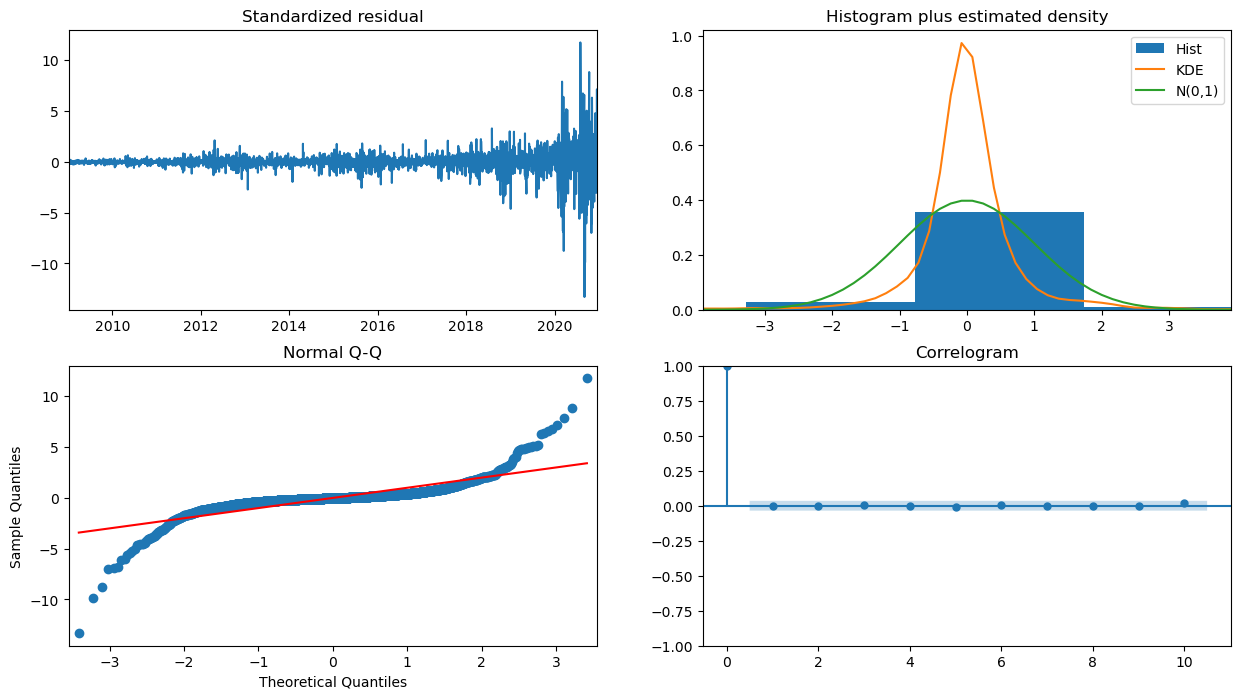

In [103]:
from pmdarima import auto_arima
# run an auto_arima function to find optimal values for p, q and d parameters
model_autoARIMA = auto_arima(train_data_d, start_p=0, start_q=0, test='adf', max_p=15, max_q=15, m=1, d=None, 
                             seasonal=False, start_P=0, D=0, trace=True, stepwise=True)

print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

<a id='4.2.2'></a>
The `auto_arima` function gave us the optimal values (9, 0, 0), for the p, d, q parameters, respectivelly. We can now fit our model based on these values.

In [106]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math

In [107]:
# fit ARIMA model
p_param = 9
d_param = 0
q_param = 0

model = ARIMA(train_data_d, order=(p_param, d_param, q_param))

aapl_fitted = model.fit()

predictions = aapl_fitted.predict(start=first_day_test_d, end=last_day_test_d)

predictions_diff = aapl_fitted.predict(start=first_day_test_d, end=last_day_test_d)

aapl_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Diff   No. Observations:                 3117
Model:                 ARIMA(9, 0, 0)   Log Likelihood               -3840.910
Date:                Sun, 04 Feb 2024   AIC                           7703.821
Time:                        18:39:17   BIC                           7770.312
Sample:                    01-06-2009   HQIC                          7727.691
                         - 12-16-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0400      0.015      2.703      0.007       0.011       0.069
ar.L1         -0.0995      0.007    -15.249      0.000      -0.112      -0.087
ar.L2         -0.0215      0.007     -3.279      0.001      -0.034      -0.009
ar.L3          0.0348      0.005      6.473      0.000       0.024       0.045
ar.L4         -0.0126      0.006     -2.001      0.045      -0.025      -0.000
ar.L5          0.0470      0.006      7.587      0.000       0.035       0.059
ar.L6         -0.0398      0.006     -6.385      0.000      -0.052      -0.028
ar.L7          0.0768      0.006     12.017      0.000       0.064       0.089
ar.L8         -0.1033      0.007    -15.656      0.000      -0.116      -0.090
ar.L9          0.0870      0.007     12.763      0.000       0.074       0.100
sigma2         0.6883      0.004    154.614      0.000       0.680       0.697
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            153640.35
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):              32.13   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                        37.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

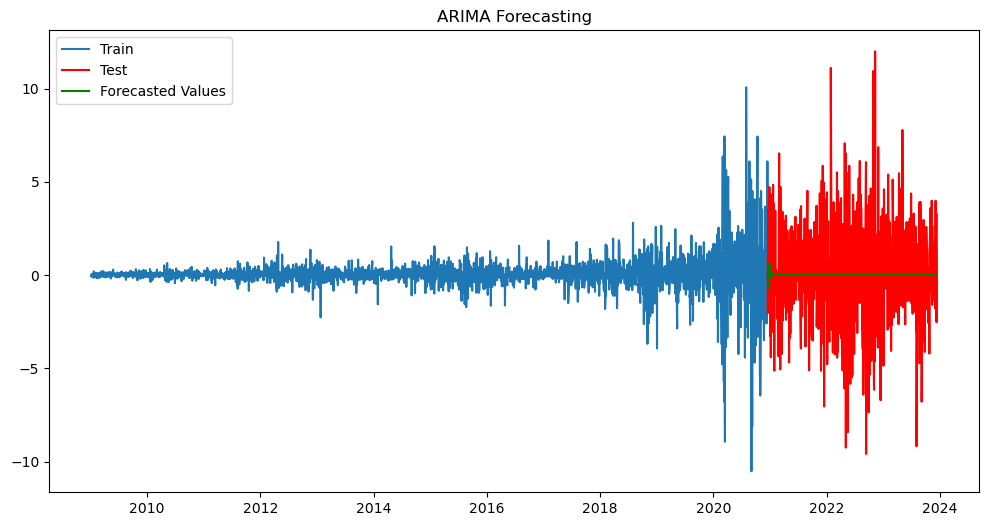

In [108]:
# plot the prediction
plt.figure(figsize=(12, 6))
plt.plot(train_data_d, label='Train')
plt.plot(test_data_d, color='red', label='Test')
plt.plot(predictions, color='green', label='Forecasted Values')
plt.legend()
plt.title('ARIMA Forecasting')
plt.show()

<a id='4.2.3'></a>
In order to plot the prediction over the original values we should revert the differenced data.

In [111]:
# revert the differenced test_data
test_data_reversed = test_data_d.cumsum()

test_data_reversed.fillna(aapl_df_clean['Close'][0], inplace=True)

C:\Users\vitor\AppData\Local\Temp\ipykernel_15856\3856652559.py:4: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [113]:
# revert differencing to obtain predictions in the original scale
predictions_diff_reverted = train_data_d.iloc[-1] + predictions_diff.cumsum()

In [114]:
# get the forecast values
forecast = aapl_fitted.get_forecast(steps=len(test_data_d))

forecast_diff = forecast.predicted_mean
forecast_original = train_data_d.iloc[-1] + forecast_diff.cumsum()
# get the confidence interval for the forecast
forecast_ci = aapl_fitted.get_forecast(steps=len(test_data_d)).conf_int(alpha=0.05)
forecast_ci_original = train_data_d.iloc[-1] + forecast_ci.cumsum()

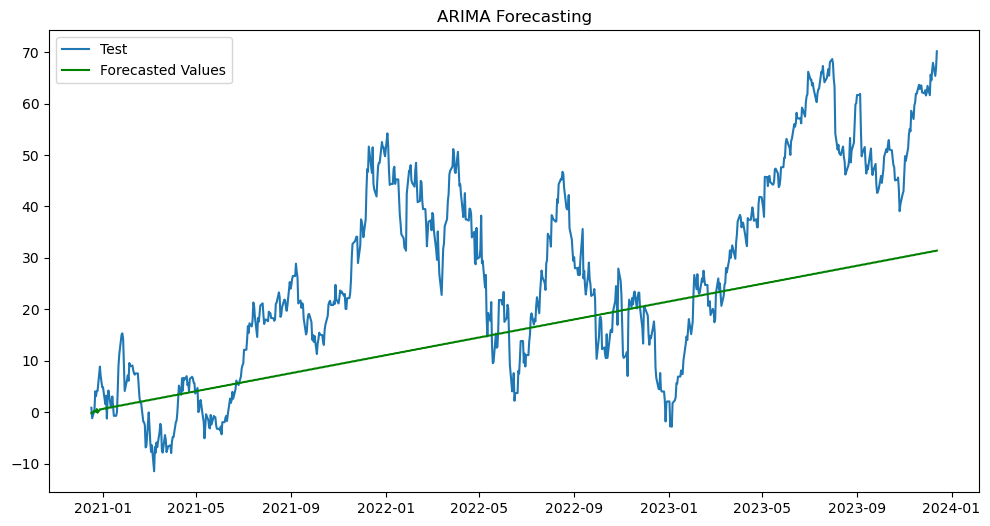

In [115]:
# plot the prediction over the reversed data
plt.figure(figsize=(12, 6))
plt.plot(test_data_reversed, label='Test')
#plt.plot(test_data, color='red', label='Test')
plt.plot(predictions_diff_reverted, color='green', label='Forecasted Values')
plt.legend()
plt.title('ARIMA Forecasting')
plt.show()

In [116]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math

mse = mean_squared_error(test_data_d, predictions[test_data_d.index])
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data_d, predictions[test_data_d.index])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data_d, predictions[test_data_d.index]))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(predictions[test_data_d.index] - test_data_d)/np.abs(test_data_d))
rounded_mape = round(mape, 2)
print('MAPE: '+str(rounded_mape))

MSE: 6.875438420349111
MAE: 1.9519648971718804
RMSE: 2.622105722572816
MAPE: inf


### Conclusion

After plotting the prediction of our ARIMA model over the original shape of the Apple stock chart we can see the model did a fairly decent job in predicting the trend of the price. Both the prediction and the data of the test set seem to move following a similar average.

The accuracy metrics, on the other hand, are not very desirable. Next we can try fitting the returns to the model or perhaps reviewing the necessity of working with stationary data. 

On another notebook we'll take the first steps presented here and fit our data to neural networks in order to try forecasting better results. For now, we'll end this exploration here.